In [70]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [2]:
VFILE = "../data/contest-example.mp4"

In [3]:
# get the video 
def get_frames(filename):
    video = cv2.VideoCapture(filename)
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            yield frame
        else:
            break
    video.release()
    yield None

In [83]:
# play the whole video
for f in get_frames(VFILE):
    if f is None: 
        break
    cv2.imshow('frame', f)
    if cv2.waitKey(30) == 27:
        break
cv2.destroyAllWindows()

In [4]:
# get specific frame 
def get_frame(filename, index):
    counter = 0
    video = cv2.VideoCapture(filename)
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            if counter == index:
                return frame
            counter += 1
        else: 
            break
    video.release()
    return None

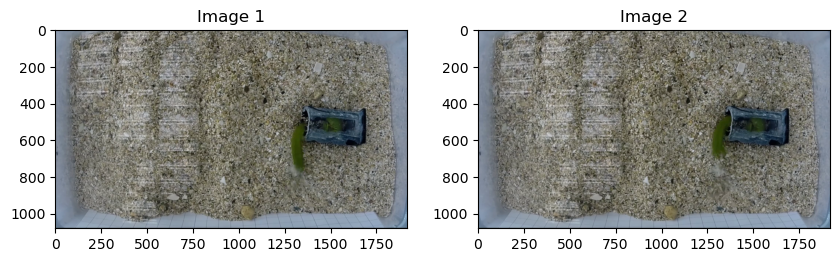

In [38]:
# get two sequential frames
i = 34
frame = get_frame(VFILE, i)
frame1 = get_frame(VFILE, i+1)
fix_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fix_frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
fig, axs = plt.subplots(1,2, figsize = (10,5))

axs[0].imshow(fix_frame, cmap = "gray")
axs[0].set_title('Image 1')
axs[1].imshow(fix_frame1, cmap = "gray")
axs[1].set_title('Image 2')
plt.show()

In [98]:
ini_sposition = []
ini_bposition = []
ini_color = []
def mouseInfo(event, x, y, flags, param):
    global ini_sposition, ini_bposition
    if event == cv2.EVENT_LBUTTONDOWN:
        ini_color.append(frame[y,x])
        ini_sposition.append((x,y))
        cv2.circle(frame, (x,y), 3, (255,255,255), 1)
        cv2.imshow("shrimp", frame)
    if event == cv2.EVENT_RBUTTONDOWN:
        ini_bposition.append((x,y))
        cv2.circle(frame, (x,y), 1, (0,0,255), -1)
        cv2.imshow("shrimp", frame)

In [99]:
counter = 0
for frame in get_frames(VFILE):
    if frame is None:
        break
    ini_sposition = []
    ini_bposition = []
    cv2.imshow('shrimp', frame) # set window name as "shrimp"
    cv2.setMouseCallback('shrimp', mouseInfo) # let Opencv listen to any event happened on window "shrimp"
    k = cv2.waitKey(0) # wait infinite time to proceed to the next frame until we press a key
    if k == 27:
        break # exist the window if the key is "esc"(27)
    counter += 1
cv2.destroyAllWindows()
ini_frame = counter
print(ini_sposition)
print(ini_bposition)
print(ini_frame)
print(ini_color)


[(1321, 669), (1530, 507)]
[]
0
[array([ 4, 76, 63], dtype=uint8), array([30, 61, 43], dtype=uint8)]


In [108]:
counter = 0
pcenter = []
size = (1080, 1960)
writer = cv2.VideoWriter('corr-demo.avi', 
                         -1,
                         30, size)
for frame in get_frames(VFILE):
    if frame is None: 
        break
    if counter < ini_frame:
        counter += 1
        continue
    elif counter == ini_frame: 
        # select templates on the initial shrimp positions
        templates = []
        for i in range(len(ini_sposition)):
            x_ini = ini_sposition[i][0] - 16
            y_ini = ini_sposition[i][1] - 16
            x_end = x_ini + 32
            y_end = y_ini + 32
            # creates templates for correlation calculation in the next frame
            templates.append(frame[y_ini:y_end, x_ini:x_end]) 
        w, h = templates[0].shape[0], templates[0].shape[1]
        counter += 1
        continue
    else:
        global pcenter
        result = np.full((frame.shape[0] - 31, frame.shape[1] - 31), 0).astype(np.float64)
        for i in templates:
            corr = cv2.matchTemplate(frame, i, 3)
            corr[corr < 0.97] = 0
            corr[corr != 0] = 255
            result += corr
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
        result = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel)
        result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel)
        row_indices, col_indices = np.nonzero(result)
        Z = np.hstack((row_indices.reshape(len(row_indices),1), col_indices.reshape(len(col_indices),1)))
        # convert to np.float32
        Z = np.float32(Z)
        # define criteria and apply kmeans()
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        ret,label,center=cv2.kmeans(Z, len(ini_sposition), None,criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        center1 = (center[0][1].astype(np.int64),center[0][0].astype(np.int64))
        center2 = (center[1][1].astype(np.int64),center[1][0].astype(np.int64))
        center_frame = np.full((result.shape[0], result.shape[1], 3), 255).astype(np.uint8)
        distance = math.sqrt((center2[0] - center1[0]) ** 2 + (center2[1] - center1[1]) ** 2)
        if distance <= 100:
            new_center1 = (((center1[0] + center2[0])/2).astype(np.int64), ((center1[1] + center2[1])/2).astype(np.int64))
            frame = cv2.circle(frame, new_center1, radius=5, color=(0,0,255), thickness=-1)
            new_dist1 = math.sqrt((new_center[0] - pcenter[0][0]) ** 2 + (new_center[1] - pcenter[0][1]) ** 2)
            new_dist2 = math.sqrt((new_center[0] - pcenter[1][0]) ** 2 + (new_center[1] - pcenter[1][1]) ** 2)
            if new_dist1 <= new_dist2:
                new_center2 = pcenter[1]
                pcenter = [new_center1, new_center2]
            else:
                new_center2 = pcenter[0]
                pcenter = [new_center2, new_center1]
            cv2.circle(frame, new_center2, radius=5, color=(0,0,255), thickness=-1)
        else:
            frame = cv2.circle(frame, center1, radius=5, color=(255,0,0), thickness=-1)
            frame = cv2.circle(frame, center2, radius=5, color=(0,255,0), thickness=-1)
            pcenter = [center1, center2]
        writer.write(frame)
        cv2.imshow("window", frame)
        counter += 1
    if cv2.waitKey(20) == 27:
        break
writer.release
cv2.destroyAllWindows()


In [92]:
x = ini_sposition[0][0] - 16
y = ini_sposition[0][1] - 16
x_end = x + 32
y_end = y + 32
frame = get_frame(VFILE, 0)
fixed_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cropped = fixed_frame[y:y_end, x:x_end,]
cropped.shape

(32, 32, 3)